<a href="https://colab.research.google.com/github/gtyellow/PredictiveMaintenance/blob/main/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code takes a dataset of machine and tries to model a predictive maintenance schedule
# The goal is to keep the equipment in service for as long as possible while avoiding equipment failure before maintenance must be performed or equipment replaced
# This appears to be a classification problem to predict when there will be a failure.  
# The model will be structured such that you can feed a production schedule into the model and estimate a failure.
# Dataset sourced from UC Irvine https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset#, 
#   who sourced it from Stephan Matzka, University of Technology and Life, Berlin

In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [ ]:
"""

The dataset consists of 10 000 data points stored as rows with 14 features in columns
UID: unique identifier ranging from 1 to 10000
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

"""

"\n\nThe dataset consists of 10 000 data points stored as rows with 14 features in columns\nUID: unique identifier ranging from 1 to 10000\nproduct ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number\nair temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K\nprocess temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.\nrotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise\ntorque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.\ntool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a\n'machine failure' label that indicates, whether the machine has failed in this particular datap

In [ ]:
#Import Libraries

import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, norm
from scipy.signal import argrelextrema

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split



In [ ]:
# next import dataset

df=pd.read_csv("/content/ai4i2020.csv")
print(df.columns)


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')


In [ ]:
df=df.drop(['UDI','Product ID'], axis=1)


In [ ]:
#Convert Kelvin to Fairenheight and relabel columns for better understanding

df['Air temperature [K]']=(df['Air temperature [K]'].values - 273.15) * 9/5 + 32
df['Process temperature [K]']=(df['Process temperature [K]'].values - 273.15) * 9/5 + 32

df.rename(columns = {'Process temperature [K]':'Process temperature [F]', 'Air temperature [K]':'Air temperature [F]'}, inplace = True)


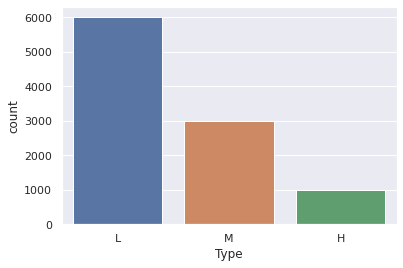

In [ ]:
#First we try to glean some information from the data by plotting features.  

sns.set(style="darkgrid")
ax=sns.countplot(x=df["Type"], order=["L", "M", "H"], data=df)
plt.show()



                   variable  value
0         tool wear failure     46
1  heat dissipation failure    115
2             power failure     95
3        overstrain failure     98
4           random failures     19


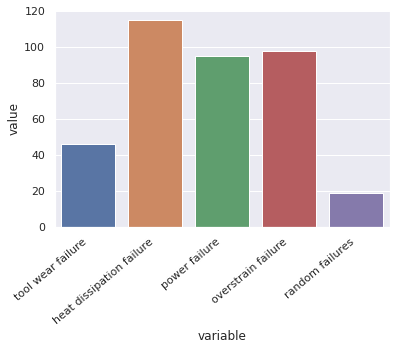

<Figure size 1440x1152 with 0 Axes>

In [ ]:

failure_df=pd.DataFrame([(np.count_nonzero(df['TWF']), 
                         np.count_nonzero(df['HDF']),
                         np.count_nonzero(df['PWF']),
                         np.count_nonzero(df['OSF']),
                         np.count_nonzero(df['RNF']))],
                        columns=["tool wear failure",
                                "heat dissipation failure",
                                "power failure",
                                "overstrain failure",
                                "random failures"] )




#print(failure_df)

melt_df=failure_df.melt(value_vars=failure_df.columns)
print(melt_df)



ax=sns.barplot(data=melt_df, x='variable', y='value')
plt.figure(figsize=(20,16))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


     Type  Air temperature [F]  Process temperature [F]  \
50      L                78.35                    96.71   
69      L                78.35                    96.53   
77      L                78.17                    96.35   
160     L                77.45                    95.09   
161     L                77.27                    94.91   
...   ...                  ...                      ...   
9758    L                77.81                    97.97   
9764    L                77.63                    97.43   
9822    L                77.63                    97.25   
9830    L                77.27                    97.07   
9974    L                77.81                    95.09   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
50                      2861          4.6              143                1   
69                      1410         65.7              191                1   
77                      1455         41.3             

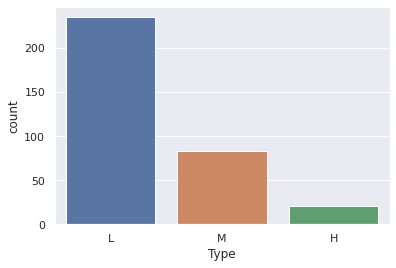

In [ ]:
failure_feature_df = df[df['Machine failure'] == 1].copy()
print(failure_feature_df)
sns.set(style="darkgrid")
ax=sns.countplot(x=failure_feature_df["Type"], order=["L", "M", "H"], data=df)
plt.show()

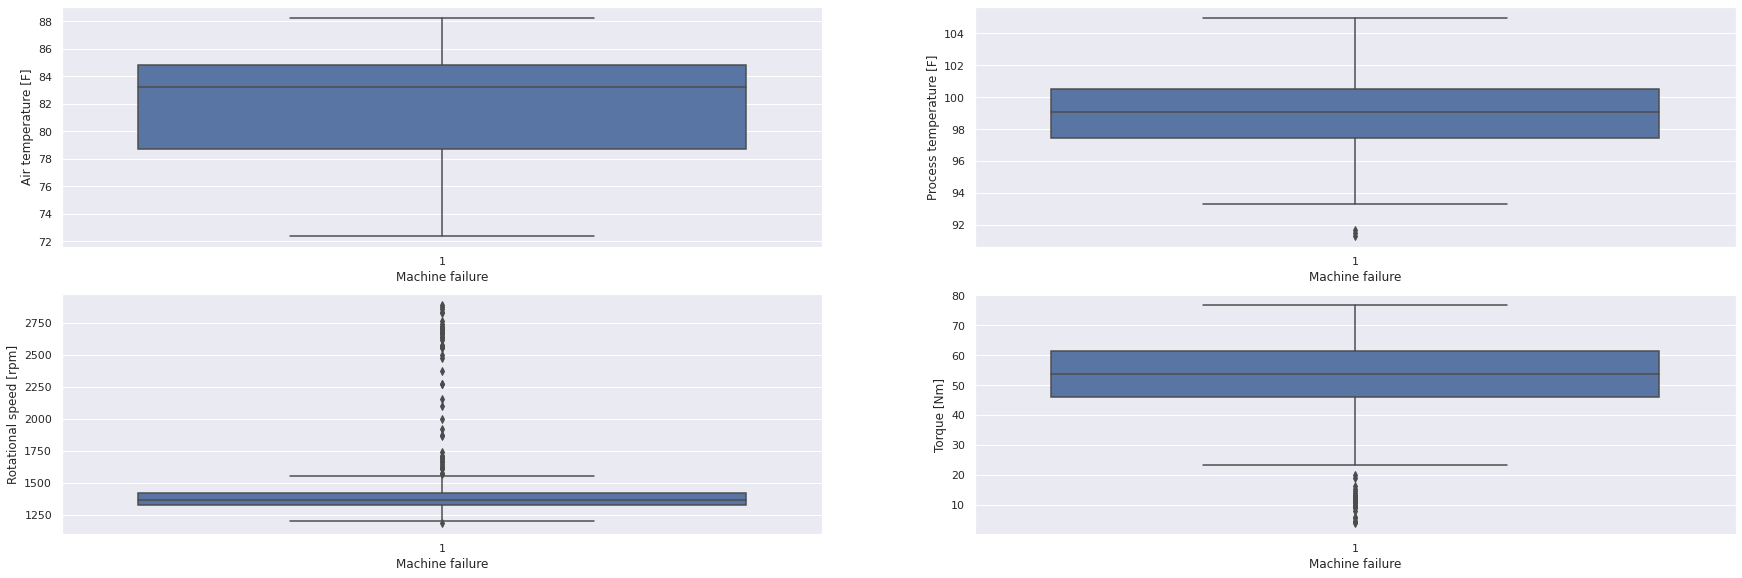

In [ ]:
plt.figure(figsize=(30,15))
count=1
for i in ['Air temperature [F]', 'Process temperature [F]', 'Rotational speed [rpm]', 'Torque [Nm]']:
  plt.subplot(3,2,count)
  sns.boxplot(data=failure_feature_df, y=i, x='Machine failure')
  count+=1

In [ ]:
#The independent variables have dramatically different ranges and must be normalized.   

# remove the machine failure column since it duplicates the five types of failure and will cause problems with the machine learning alogorythm

failure_feature_df=failure_feature_df.drop(['Machine failure'], axis=1)

In [ ]:
hot_encoded_df = pd.get_dummies(df, columns=["Type"], prefix="Prod Type")

In [ ]:
print(hot_encoded_df)

      Air temperature [F]  Process temperature [F]  Rotational speed [rpm]  \
0                   76.91                    95.81                    1551   
1                   77.09                    95.99                    1408   
2                   76.91                    95.63                    1498   
3                   77.09                    95.81                    1433   
4                   77.09                    95.99                    1408   
...                   ...                      ...                     ...   
9995                78.17                    95.45                    1604   
9996                78.35                    95.45                    1632   
9997                78.53                    95.81                    1645   
9998                78.53                    95.99                    1408   
9999                78.53                    95.99                    1500   

      Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  

In [ ]:
y = df['Machine failure']
#y = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].copy()
X = hot_encoded_df.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)



 
# Now we split the dataset in train and test part
# here the train set is 75% and test set is 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  random_state=2)


print(X_train.shape)
print(y_train.shape)

(7500, 8)
(7500,)


In [ ]:

#Now we develop several models using sklearn and compare them for accuracy
#Frist Import several models as well as a way to compare them

import time
from sklearn.metrics import accuracy_score, classification_report

classifier=[]
import_model=[]

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
classifier.append('Logistic Regression')
import_model.append('lr')

from sklearn.svm import SVC
SVC=SVC()
classifier.append('Support Vector Machine')
import_model.append('SVC')

from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
classifier.append('Gaussian Naive Bayes')
import_model.append('GNB')

from sklearn.linear_model import SGDClassifier
SGDC = SGDClassifier()
classifier.append('Stochastic Gradient Descent Classifier')
import_model.append('SGDC')

from sklearn.ensemble import BaggingClassifier
BC = BaggingClassifier()
classifier.append('Bagging Classifier')
import_model.append('BC')


In [ ]:
class Modeling:
  def __init__ (self, X_train, X_test, y_train, y_test, models):
    self.X_train = X_train    
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.models = models


  def fit(self):
    model_time = []
    model_accuracy = []
    for i in self.models:
      start=time.time()
      i.fit(self.X_train, self.y_train)
      model_accuracy.append(accuracy_score(self.y_test, i.predict(self.X_test)))
      stop=time.time()
      model_time.append(stop-start)
      print(i, "has been fit")
    self.models_output = pd.DataFrame({'Models':self.models, 'Accuracy':model_accuracy, 'Runtime (s)':model_time})
  
  def results(self):
    models=self.models_output
    models=models.sort_values(by=['Accuracy', 'Runtime (s)'],ascending=[False,True]).reset_index().drop('index', axis=1)
    self.best = models['Models'][0]
    models['Models']=models['Models'].astype(str).str.split('(', n=2, expand = True)[0]
    models['Accuracy']=models['Accuracy'].round(5)*100
    self.models_output_cleaned=models
    return(models)
  
  def best_model(self, type):
    if type=='model':
      return(self.best)
    elif type=='name':
      return(self.models_output_cleaned['Models'][0])

  def best_model_accuracy(self):
    return(self.models_output_cleaned['Accuracy'][0])

  def best_model_predict(self,X_test):
    return(self.best.predict(X_test))



In [ ]:
#models_to_test=[lr]
models_to_test=[lr, SVC, GNB, SGDC, BC]


In [ ]:
classification = Modeling(X_train, X_test, y_train, y_test, models_to_test)
classification.fit()

LogisticRegression() has been fit
SVC() has been fit
GaussianNB() has been fit
SGDClassifier() has been fit
BaggingClassifier() has been fit


In [ ]:
classification.results()

,Models,Accuracy,Runtime (s)
0,BaggingClassifier,98.56,0.261784
1,LogisticRegression,97.08,0.148627
2,SGDClassifier,96.72,0.054091
3,SVC,96.72,0.419090
4,GaussianNB,95.28,0.008090
